In [4]:
!pip install scikit-survival
!pip install lifelines
!pip install --upgrade scikit-survival

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter, WeibullAFTFitter
from sklearn.inspection import permutation_importance
from sksurv.metrics import concordance_index_censored

In [6]:
df = pd.read_csv("Tree_Data_Augmented.csv")
df.head()

,Species,Light_ISF,Light_Cat,Soil,Sterile,Conspecific,Myco_type,AMF,Phenolics,Lignin,NSC,Census,Time,Event,PlantSeason,EMF_log,Synthetic
0,Acer saccharum,0.106,Med,Prunus serotina,Non-Sterile,Heterospecific,AMF,22.00,-0.56,13.86,12.15,4.0,14.0,1,Monsoon,3.357594,0
1,Quercus alba,0.106,Med,Quercus rubra,Non-Sterile,Heterospecific,EMF,15.82,5.19,20.52,19.29,33.0,115.5,0,Summer,3.467921,0
2,Quercus rubra,0.106,Med,Prunus serotina,Non-Sterile,Heterospecific,EMF,24.45,3.36,24.74,15.01,18.0,63.0,1,Summer,3.373826,0
3,Acer saccharum,0.080,Med,Prunus serotina,Non-Sterile,Heterospecific,AMF,22.23,-0.71,14.29,12.36,4.0,14.0,1,Monsoon,3.357594,0
4,Acer saccharum,0.060,Low,Prunus serotina,Non-Sterile,Heterospecific,AMF,21.15,-0.58,10.85,11.20,4.0,14.0,1,Monsoon,3.357594,0


In [7]:
df.shape

(5564, 17)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5564 entries, 0 to 5563
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Species      5564 non-null   object 
 1   Light_ISF    5564 non-null   float64
 2   Light_Cat    5564 non-null   object 
 3   Soil         5564 non-null   object 
 4   Sterile      2782 non-null   object 
 5   Conspecific  2782 non-null   object 
 6   Myco_type    5564 non-null   object 
 7   AMF          5564 non-null   float64
 8   Phenolics    5564 non-null   float64
 9   Lignin       5564 non-null   float64
 10  NSC          5564 non-null   float64
 11  Census       5564 non-null   float64
 12  Time         5564 non-null   float64
 13  Event        5564 non-null   int64  
 14  PlantSeason  5564 non-null   object 
 15  EMF_log      5564 non-null   float64
 16  Synthetic    5564 non-null   int64  
dtypes: float64(8), int64(2), object(7)
memory usage: 739.1+ KB


In [9]:
df.describe()

,Light_ISF,AMF,Phenolics,Lignin,NSC,Census,Time,Event,EMF_log,Synthetic
count,5564.000000,5564.000000,5564.000000,5564.000000,5564.000000,5564.000000,5564.000000,5564.000000,5564.000000,5564.000000
mean,0.086058,20.388557,1.933688,15.786626,14.171605,15.273631,45.480697,0.489396,3.185208,0.500000
std,0.026222,11.794481,1.977753,6.764302,4.292574,9.099982,28.460293,0.499932,0.717277,0.500045
min,0.032000,0.000000,-1.350000,2.230000,4.300000,4.000000,6.000000,0.000000,0.000000,0.000000
25%,0.066000,13.400000,0.169922,10.331514,11.600688,7.050002,24.500000,0.000000,3.314399,0.000000
50%,0.082000,18.000000,0.778749,14.140000,12.714275,12.899198,40.900000,0.000000,3.357594,0.500000
75%,0.102138,24.553549,3.780000,21.130000,17.032500,18.000000,57.100000,1.000000,3.392706,1.000000
max,0.161000,62.620000,6.100000,32.770000,29.450000,33.000000,115.500000,1.000000,4.483003,1.000000


In [10]:
duration_col = "Time"
event_col = "Event"

X = df.drop(columns=[duration_col, event_col])
y_time = df[duration_col]
y_event = df[event_col]

In [11]:
X_train, X_test, y_time_train, y_time_test, y_event_train, y_event_test = train_test_split(
    X, y_time, y_event,
    test_size=0.2,
    random_state=42
)

In [12]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(num_cols)
print(cat_cols)

['Light_ISF', 'AMF', 'Phenolics', 'Lignin', 'NSC', 'Census', 'EMF_log', 'Synthetic']
['Species', 'Light_Cat', 'Soil', 'Sterile', 'Conspecific', 'Myco_type', 'PlantSeason']


# **Feature Encoding**

In [13]:
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat  = ohe.transform(X_test[cat_cols])

In [14]:
X_train_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 1., 1.]])

In [15]:

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num  = scaler.transform(X_test[num_cols])

In [16]:
X_train_final = np.hstack([X_train_num, X_train_cat])
X_test_final  = np.hstack([X_test_num, X_test_cat])

# Feature names
feature_names = (
    list(num_cols) +
    list(ohe.get_feature_names_out(cat_cols))
)

# Final DataFrames (AFT requires DataFrame)
df_train_final = pd.DataFrame(X_train_final, columns=feature_names)
df_test_final  = pd.DataFrame(X_test_final, columns=feature_names)

# Add survival targets
df_train_final["Time"] = y_time_train.values
df_train_final["Event"] = y_event_train.values

df_test_final["Time"] = y_time_test.values
df_test_final["Event"] = y_event_test.values

# Modeling

In [17]:
aft = WeibullAFTFitter(penalizer=0.1)

aft.fit(
    df_train_final,
    duration_col="Time",
    event_col="Event"
)

aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 4451 total observations, 2284 right-censored observations>
             duration col = 'Time'
                event col = 'Event'
                penalizer = 0.1
   number of observations = 4451
number of events observed = 2167
           log-likelihood = -10692.02
         time fit was run = 2026-01-11 16:30:25 UTC

---
                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                   
lambda_ AMF                        -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99
        Census                      0.28      1.32      0.01            0.25            0.30                1.29                1.35
        Conspecific_Heterospecific  0.02      1.02      0.03           -0.04            0.09                0.96                1.09
        Conspecific_Sterilized      0.09      1.09      0.13           -0.17            0.34                0.84                1.41
        Conspecific_nan             0.04      1.05      0.08           -0.11            0.20                0.90                1.22
        EMF_log                     0.00      1.00      0.01           -0.02            0.03                0.98                1.03
        Light_Cat_Low              -0.11      0.89      0.03           -0.18           -0.05                0.84                0.95
        Light_Cat_Med              -0.08      0.93      0.03           -0.14           -0.01                0.87                0.99
        Light_ISF                  -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
        Lignin                      0.03      1.03      0.01            0.01            0.05                1.01                1.06
        Myco_type_EMF               0.21      1.23      0.03            0.16            0.26                1.17                1.29
        NSC                         0.02      1.02      0.01            0.00            0.04                1.00                1.05
        Phenolics                   0.07      1.07      0.01            0.05            0.09                1.05                1.10
        PlantSeason_Summer          0.05      1.05      0.02            0.01            0.10                1.01                1.10
        Soil_Acer saccharum        -0.02      0.98      0.03           -0.08            0.05                0.92                1.05
        Soil_Populus grandidentata -0.05      0.95      0.03           -0.11            0.02                0.89                1.02
        Soil_Prunus serotina       -0.03      0.97      0.03           -0.09            0.04                0.91                1.04
        Soil_Quercus alba          -0.02      0.98      0.03           -0.09            0.04                0.92                1.04
        Soil_Quercus rubra         -0.01      0.99      0.03           -0.07            0.05                0.93                1.06
        Soil_Sterile               -0.13      0.88      0.04           -0.21           -0.05                0.81                0.95
        Species_Prunus serotina     0.07      1.07      0.02            0.02            0.12                1.02                1.12
        Species_Quercus alba        0.08      1.08      0.03            0.02            0.14                1.02                1.15
        Species_Quercus rubra       0.15      1.17      0.03            0.10            0.21                1.10                1.24
        Sterile_Sterile             0.09      1.09      0.13           -0.17            0.34                0.84                1.41
        Sterile_nan                 0.04      1.05      0.08           -0.11            0.20                0.90                1.22
        Synthetic                   0.02     

In [18]:
aft_train_cindex = aft.concordance_index_
aft_train_cindex

np.float64(0.6994077275249297)

In [19]:
aft_test_cindex = aft.score(df_test_final,scoring_method="concordance_index")
aft_test_cindex

np.float64(0.6938233806612788)

In [20]:
sample = df_test_final.drop(columns=["Time", "Event"]).iloc[[0]]
surv_fn = aft.predict_survival_function(sample)
print(surv_fn.head())

            0
6.0  0.999551
6.1  0.999533
6.2  0.999515
6.3  0.999496
6.4  0.999477


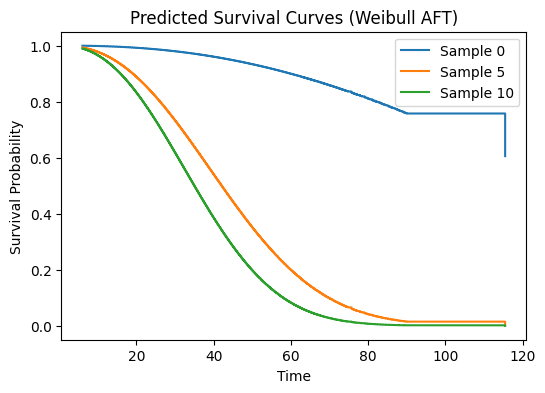

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

for i in [0, 5, 10]:
    sample = df_test_final.drop(columns=["Time", "Event"]).iloc[[i]]
    surv_fn = aft.predict_survival_function(sample)
    plt.step(surv_fn.index, surv_fn.iloc[:, 0], where="post", label=f"Sample {i}")

plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Predicted Survival Curves (Weibull AFT)")
plt.legend()
plt.show()

In [22]:
from sksurv.util import Surv

y_rsf_train = Surv.from_arrays(
    event=y_event_train.astype(bool),
    time=y_time_train
)

y_rsf_test = Surv.from_arrays(
    event=y_event_test.astype(bool),
    time=y_time_test
)

In [23]:
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X_train_final, y_rsf_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=300, n_jobs=-1, random_state=42)

In [24]:
rsf_train_cindex = concordance_index_censored(y_event_train.astype(bool),y_time_train,rsf.predict(X_train_final))[0]
rsf_train_cindex

np.float64(0.8229763987332557)

In [25]:
rsf_test_cindex = concordance_index_censored(y_event_test.astype(bool), y_time_test,rsf.predict(X_test_final))[0]
rsf_test_cindex

np.float64(0.702748709314995)

In [26]:
perm_result = permutation_importance(
    rsf,
    X_test_final,
    y_rsf_test,
    n_repeats=10,
    random_state=42,
    n_jobs=1
)

rsf_importance = pd.Series(
    perm_result.importances_mean,
    index=feature_names
).sort_values(ascending=False)

print(rsf_importance.head(15))

Census                        0.084975
Phenolics                     0.006920
Myco_type_EMF                 0.005036
PlantSeason_Summer            0.002838
Sterile_nan                   0.002792
Synthetic                     0.002437
Light_Cat_Low                 0.002430
Soil_Sterile                  0.001826
Conspecific_nan               0.001030
Light_Cat_Med                 0.000913
NSC                           0.000443
Sterile_Sterile               0.000375
Soil_Populus grandidentata    0.000196
Species_Quercus alba          0.000181
Conspecific_Sterilized        0.000162
dtype: float64


The dataset is highly right-censored, meaning most trees survive during early observation periods. Survival analysis therefore predicts near-unity survival probabilities at short horizons. Meaningful risk differentiation emerges at longer time horizons, which is why the application allows survival estimates beyond multiple years.

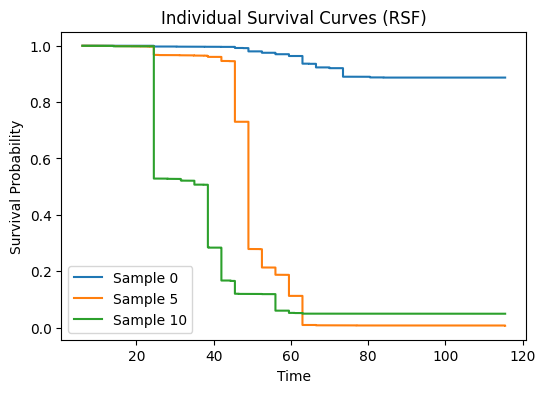

In [27]:
plt.figure(figsize=(6,4))
for i in [0, 5, 10]:
    surv = rsf.predict_survival_function(X_test_final[i:i+1])[0]
    plt.step(surv.x, surv.y, where="post", label=f"Sample {i}")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.title("Individual Survival Curves (RSF)")
plt.legend()
plt.show()

# Model Evaluation

In [28]:
evaluation_df = pd.DataFrame({
    "Model": ["Weibull AFT", "Random Survival Forest"],
    "Train C-Index": [aft_train_cindex, rsf_train_cindex],
    "Test C-Index": [aft_test_cindex, rsf_test_cindex]
})

print(evaluation_df)

                    Model  Train C-Index  Test C-Index
0             Weibull AFT       0.699408      0.693823
1  Random Survival Forest       0.822976      0.702749


# Model Deployment

In [29]:
import joblib

joblib.dump(ohe, "encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(aft, "weibull_aft_model.pkl")
joblib.dump(feature_names, "feature_names.pkl")

['feature_names.pkl']